In [23]:
import os
import re
from collections import defaultdict
from copy import copy

In [24]:
log_filename = "sirs_zhong.log"
dim = 50,50
patt_out_line = ".*Y / (?P<time>[0-9]{2}:[0-9]{2}:[0-9]{2}:[0-9]{3})(?::0)? / [a-zA-Z0-9]+\((?P<x>[0-9]+),(?P<y>[0-9]+)\)\([0-9]+\) / out_(?P<state>(?:inf|inc|lat|rec|sus)_[0-9]+) / +(?P<perc>[0-9.-]+) (?:/|para) [a-zA-Z0-9]+\([0-9]+\)"

In [25]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INCUBATION = "#f1c40f"
COLOR_INFECTED = "#e74c3c"
COLOR_LATENT = "#c0392b"
COLOR_RECOVERED = "#2ecc71"

In [26]:
def time_str_to_ts(time_str):
  patt_time = "([0-9]{2}):([0-9]{2}):([0-9]{2}):([0-9]{3})"
  match = re.match(patt_time, time_str)
  if not match:
    raise RuntimeError("Error converting simulation time")
  tu = list(map(int, match.groups()))
  return tu[3] + tu[2]*1000 + tu[1]*60000 + tu[0]*3600000

def curr_states_to_df_row(sim_time, states, curr_states):
    sus_acc = 0
    inc_acc = 0
    inf_acc = 0
    lat_acc = 0
    rec_acc = 0
    for i in range(len(curr_states)):
        for j in range(len(curr_states[0])):
            curr_states[i][j][0] = 1 - sum(curr_states[i][j][1:])
            
            for st_name, st_value in zip(states, curr_states[i][j]):
                if st_name.startswith("sus"):
                    sus_acc += st_value
                elif st_name.startswith("inc"):
                    inc_acc += st_value
                elif st_name.startswith("inf"):
                    inf_acc += st_value
                elif st_name.startswith("lat"):
                    lat_acc += st_value
                elif st_name.startswith("rec"):
                    rec_acc += st_value
                else:
                    raise RuntimeError("State not recognized")
            
    num_cells = len(curr_states) * len(curr_states[0])
    sus_acc /= num_cells
    inc_acc /= num_cells
    inf_acc /= num_cells
    lat_acc /= num_cells
    rec_acc /= num_cells
    
    #print(curr_time, sus_acc + inf_acc + rec_acc)
    assert 0.99 <= sus_acc + inc_acc + inf_acc + lat_acc + rec_acc < 1.01, ([sus_acc, inc_acc, inf_acc, lat_acc, rec_acc], sus_acc + inc_acc + inf_acc + lat_acc + rec_acc)
    
    return [time_str_to_ts(sim_time)-1, sus_acc, inc_acc, inf_acc, lat_acc, rec_acc]

def reset_states(curr_states, initial_values):
    for i in range(len(curr_states)):
        for j in range(len(curr_states[0])):
            curr_states[i][j] = copy(initial_values)

In [27]:
curr_time = None
curr_states = []

for _ in range(dim[0]):
    curr_states.append([])
    for _ in range(dim[1]):
        curr_states[-1].append(None)

In [28]:
states = []
initial_values = []
data = []

with open(log_filename, "r") as log_file:
    for line in log_file:
        line = line.strip()
        match = re.match(patt_out_line, line)
        if not match:
            continue
        if curr_time is None:
            curr_time = match.group("time")
        elif curr_time != match.group("time"):
          #print("Changed to " + match.group("time"))

          #row = [time_str_to_ts(curr_time)] + dict_to_states_row(dict(state_count.items()))
            if curr_time != "00:00:00:000":
                print(curr_time)
                data.append(curr_states_to_df_row(curr_time, states, curr_states))
            else:
                initial_values = [1] + [0] * (len(states)-1)
            reset_states(curr_states, initial_values)
            print("Changing from %s to %s" % (curr_time, match.group("time")))

            curr_time = match.group("time")

        if curr_time == "00:00:00:000":
            if not int(match.group("x")) == int(match.group("y")) == 0:
                continue
            if match.group("state") not in states:
                states.append(match.group("state"))
        else:
            x = int(match.group("x"))
            y = int(match.group("y"))
            
            perc = float(match.group("perc"))
            #print(x,y,match.group("state"),perc)
            curr_states[x][y][states.index(match.group("state"))] = perc 
    
    #data.append(curr_states_to_df_row(curr_time, states, curr_states))

Changing from 00:00:00:000 to 00:00:00:001
00:00:00:001
Changing from 00:00:00:001 to 00:00:00:002
00:00:00:002
Changing from 00:00:00:002 to 00:00:00:003
00:00:00:003
Changing from 00:00:00:003 to 00:00:00:004
00:00:00:004
Changing from 00:00:00:004 to 00:00:00:005
00:00:00:005
Changing from 00:00:00:005 to 00:00:00:006
00:00:00:006
Changing from 00:00:00:006 to 00:00:00:007
00:00:00:007
Changing from 00:00:00:007 to 00:00:00:008
00:00:00:008
Changing from 00:00:00:008 to 00:00:00:009
00:00:00:009
Changing from 00:00:00:009 to 00:00:00:010
00:00:00:010
Changing from 00:00:00:010 to 00:00:00:011
00:00:00:011
Changing from 00:00:00:011 to 00:00:00:012
00:00:00:012
Changing from 00:00:00:012 to 00:00:00:013
00:00:00:013
Changing from 00:00:00:013 to 00:00:00:014
00:00:00:014
Changing from 00:00:00:014 to 00:00:00:015
00:00:00:015
Changing from 00:00:00:015 to 00:00:00:016
00:00:00:016
Changing from 00:00:00:016 to 00:00:00:017
00:00:00:017
Changing from 00:00:00:017 to 00:00:00:018
00:00

### Visualization

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [30]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [31]:
columns = ["time", "susceptible", "incubation", "infected", "latent", "recovered"]
df_vis = pd.DataFrame(data, columns=columns)
df_vis = df_vis.set_index("time")
df_vis["infected_sum"] = df_vis["incubation"] + df_vis["infected"] + df_vis["latent"] 
df_vis.to_csv("states.csv")
df_vis.head(100)

,susceptible,incubation,infected,latent,recovered,infected_sum
time,,,,,,
0,0.999880,0.000120,0.000000,0.00000,0.000000,0.000120
1,0.999760,0.000240,0.000000,0.00000,0.000000,0.000240
2,0.999572,0.000308,0.000120,0.00000,0.000000,0.000428
3,0.999240,0.000520,0.000240,0.00000,0.000000,0.000760
4,0.998696,0.000876,0.000308,0.00012,0.000000,0.001304
...,...,...,...,...,...,...
93,0.998016,0.000000,0.000000,0.00000,0.001984,0.000000
94,0.999076,0.000000,0.000000,0.00000,0.000924,0.000000
95,0.999540,0.000000,0.000000,0.00000,0.000460,0.000000


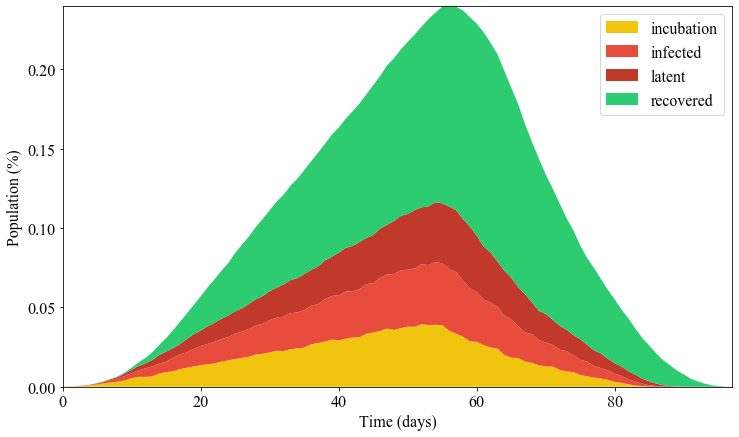

In [32]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["incubation", "infected", "latent", "recovered"]
colors=[COLOR_INCUBATION, COLOR_INFECTED, COLOR_LATENT, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_area.pdf")

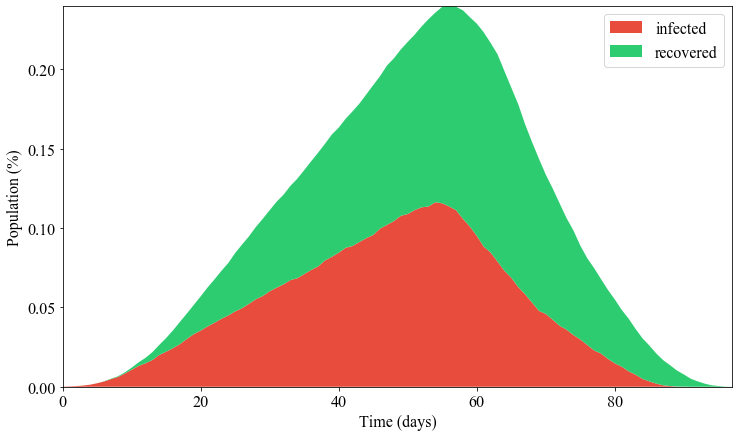

In [33]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["infected_sum", "recovered"]
labels = ["infected", "recovered"]
colors=[COLOR_INFECTED, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=labels, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_area.pdf")

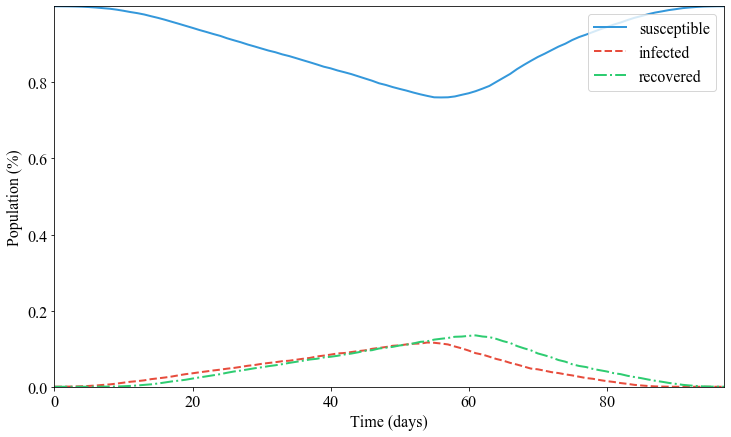

In [34]:
fig, ax = plt.subplots(figsize=(12,7))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected_sum"], label="infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["recovered"], label="recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.pdf")

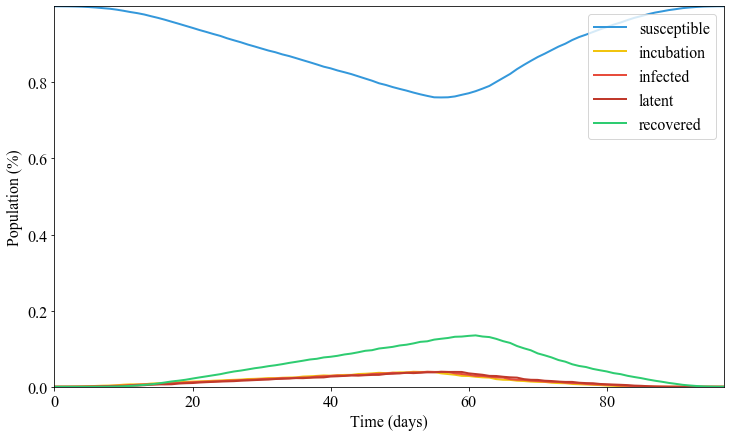

In [35]:
fig, ax = plt.subplots(figsize=(12,7))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["incubation"], label="incubation", color=COLOR_INCUBATION, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="infected", color=COLOR_INFECTED, linewidth=linewidth)
ax.plot(x, df_vis["latent"], label="latent", color=COLOR_LATENT, linewidth=linewidth)
ax.plot(x, df_vis["recovered"], label="recovered", color=COLOR_RECOVERED, linewidth=linewidth)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.pdf")